In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
import ast

Processing will be on columns : areaWithType, additionalRoom, agePossession, furnishDetails, features 

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('gurgaon_cleaned.csv')

In [4]:
df.drop(columns=['Unnamed: 0'],inplace=True)

# areaWithType

In [5]:
df.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
3421,1.42,1650.0,Super Built up area 1650(153.29 sq.m.)
3399,6.16,3000.0,Carpet area: 3000 (278.71 sq.m.)
252,0.37,450.0,Plot area 450(41.81 sq.m.)
2311,2.00,2670.0,Super Built up area 2670(248.05 sq.m.)
701,1.35,2350.0,Super Built up area 2350(218.32 sq.m.)


In [6]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [7]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [8]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
3220,13.50,house,4518.0,Plot area 502(419.74 sq.m.),NaN,NaN,NaN
2526,8.50,house,4518.0,Plot area 502(419.74 sq.m.)Built Up area: 500 ...,NaN,500.0,400.0
1751,0.83,flat,1245.0,Super Built up area 1245(115.66 sq.m.)Built Up...,1245.0,1154.0,945.0
1756,2.85,flat,1975.0,Super Built up area 1975(183.48 sq.m.),1975.0,NaN,NaN
205,7.25,house,2475.0,Plot area 275(229.94 sq.m.),NaN,NaN,NaN


In [9]:
df.duplicated().sum()

122

columns where all the three area columns are not null togather

In [10]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))].shape

(534, 20)

columns where all the three area columns are null togather

In [11]:
df[df['super_built_up_area'].isnull() & df['built_up_area'].isnull() & df['carpet_area'].isnull()].shape

(546, 20)

columns where 'areaWithType' column has Plot in it 

In [12]:
df[df['areaWithType'].str.contains('Plot')].head()

,property_type,sector,society,price,area,price_per_sqft,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
4,house,sector 56,independent,12.39,2700.0,45889.0,Plot area 300(250.84 sq.m.),16,18,3+,"pooja room,servant room",4.0,North-East,0 to 1 Year Old,"['Sector metro station', 'Sector metro station...","['4 Fan', '1 Exhaust Fan', '3 Geyser', '1 Stov...","['Feng Shui / Vaastu Compliant', 'Private Gard...",NaN,NaN,NaN
9,house,sector 9,independent,0.60,558.0,10753.0,Plot area 62(51.84 sq.m.),3,3,1,not available,2.0,NaN,1 to 5 Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Esic...","['1 Fan', '1 Light', 'No AC', 'No Bed', 'No Ch...",NaN,NaN,NaN,NaN
11,house,sector 23,independent,4.00,2499.0,16004.0,Plot area 270(225.75 sq.m.),3,3,2,servant room,2.0,East,5 to 10 Year Old,"['HUDA Sector 23 Market', 'Palam triangle', 'P...","['3 Wardrobe', '4 Fan', '1 Exhaust Fan', '2 Ge...","['Security / Fire Alarm', 'Feng Shui / Vaastu ...",NaN,NaN,NaN
20,house,sector 7,shivpuri,2.40,2700.0,8889.0,Plot area 300(250.84 sq.m.),10,5,3,"pooja room,study room,servant room",2.0,North,10+ Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Arya...","['4 Wardrobe', '9 Fan', '4 Light', 'No AC', 'N...",['Fitness Centre / GYM'],NaN,NaN,NaN
24,house,sector 43,independent,5.30,1935.0,27390.0,Plot area 215(179.77 sq.m.),9,9,3+,servant room,3.0,East,5 to 10 Year Old,"['Sector 42-43 metro station', 'Huda city cent...","['9 Wardrobe', '15 Fan', '1 Exhaust Fan', '12 ...","['Feng Shui / Vaastu Compliant', 'Private Gard...",NaN,NaN,NaN


In [13]:
df.isnull().sum()

property_type             0
sector                    0
society                   1
price                    18
area                     18
price_per_sqft           18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2616
carpet_area            1859
dtype: int64

dataframe where all the three columns are null

In [14]:
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))]
all_nan_df.head()

,property_type,sector,society,price,area,price_per_sqft,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
4,house,sector 56,independent,12.39,2700.0,45889.0,Plot area 300(250.84 sq.m.),16,18,3+,"pooja room,servant room",4.0,North-East,0 to 1 Year Old,"['Sector metro station', 'Sector metro station...","['4 Fan', '1 Exhaust Fan', '3 Geyser', '1 Stov...","['Feng Shui / Vaastu Compliant', 'Private Gard...",NaN,NaN,NaN
9,house,sector 9,independent,0.60,558.0,10753.0,Plot area 62(51.84 sq.m.),3,3,1,not available,2.0,NaN,1 to 5 Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Esic...","['1 Fan', '1 Light', 'No AC', 'No Bed', 'No Ch...",NaN,NaN,NaN,NaN
11,house,sector 23,independent,4.00,2499.0,16004.0,Plot area 270(225.75 sq.m.),3,3,2,servant room,2.0,East,5 to 10 Year Old,"['HUDA Sector 23 Market', 'Palam triangle', 'P...","['3 Wardrobe', '4 Fan', '1 Exhaust Fan', '2 Ge...","['Security / Fire Alarm', 'Feng Shui / Vaastu ...",NaN,NaN,NaN
20,house,sector 7,shivpuri,2.40,2700.0,8889.0,Plot area 300(250.84 sq.m.),10,5,3,"pooja room,study room,servant room",2.0,North,10+ Year Old,"['Chintapurni Mandir', 'State bank ATM', 'Arya...","['4 Wardrobe', '9 Fan', '4 Light', 'No AC', 'N...",['Fitness Centre / GYM'],NaN,NaN,NaN
24,house,sector 43,independent,5.30,1935.0,27390.0,Plot area 215(179.77 sq.m.),9,9,3+,servant room,3.0,East,5 to 10 Year Old,"['Sector 42-43 metro station', 'Huda city cent...","['9 Wardrobe', '15 Fan', '1 Exhaust Fan', '12 ...","['Feng Shui / Vaastu Compliant', 'Private Gard...",NaN,NaN,NaN


In [15]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))].index

In [16]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [17]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

/var/folders/8h/xtp_v7md6bs9195xxzbbf5d80000gn/T/ipykernel_2042/2542951696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)


In [18]:
all_nan_df[['area','super_built_up_area','built_up_area','carpet_area','price','areaWithType']]

,area,super_built_up_area,built_up_area,carpet_area,price,areaWithType
4,2700.0,NaN,300.0,NaN,12.39,Plot area 300(250.84 sq.m.)
9,558.0,NaN,62.0,NaN,0.60,Plot area 62(51.84 sq.m.)
11,2499.0,NaN,270.0,NaN,4.00,Plot area 270(225.75 sq.m.)
20,2700.0,NaN,300.0,NaN,2.40,Plot area 300(250.84 sq.m.)
24,1935.0,NaN,215.0,NaN,5.30,Plot area 215(179.77 sq.m.)
...,...,...,...,...,...,...
3763,4518.0,NaN,502.0,NaN,17.00,Plot area 502(419.74 sq.m.)
3768,2160.0,NaN,240.0,NaN,4.60,Plot area 240(200.67 sq.m.)
3780,4000.0,NaN,4000.0,NaN,8.40,Plot area 4000(371.61 sq.m.)
3786,2880.0,NaN,320.0,NaN,4.50,Plot area 320(267.56 sq.m.)


some values in area column are in square feet and respective cols in built_up_area are in square yards thus conversion is needed

- 9 * syard = sfeet
- 10.7 * smeter = sfeet

In [19]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [20]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

/var/folders/8h/xtp_v7md6bs9195xxzbbf5d80000gn/T/ipykernel_2042/374280303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)


In [21]:
all_nan_df[['area','built_up_area','super_built_up_area','carpet_area']]

,area,built_up_area,super_built_up_area,carpet_area
4,2700.0,2700.0,NaN,NaN
9,558.0,558.0,NaN,NaN
11,2499.0,2430.0,NaN,NaN
20,2700.0,2700.0,NaN,NaN
24,1935.0,1935.0,NaN,NaN
...,...,...,...,...
3763,4518.0,4518.0,NaN,NaN
3768,2160.0,2160.0,NaN,NaN
3780,4000.0,4000.0,NaN,NaN
3786,2880.0,2880.0,NaN,NaN


In [22]:
df.update(all_nan_df)

In [23]:
# rows where all the three cols are null altogather
df[df['super_built_up_area'].isnull() & df['built_up_area'].isnull() & df['carpet_area'].isnull()].shape

(0, 20)

In [26]:
df.head(5)

,property_type,sector,society,price,area,price_per_sqft,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
0,flat,sector 86,ansal heights 86,0.78,1360.0,5735.0,Built Up area: 1360 (126.35 sq.m.),2,2,2,not available,8.0,North,0 to 1 Year Old,"['IRIS Broadway Mall', 'Delhi Jaipur Expresswa...",NaN,"['Feng Shui / Vaastu Compliant', 'Security / F...",NaN,1360.0,NaN
1,flat,sector 103,indiabulls centrum park,1.05,1792.0,5861.0,Built Up area: 1365 (126.81 sq.m.)Carpet area:...,2,2,3,not available,1.0,West,1 to 5 Year Old,"['Gurgaon Dreamz Mall', 'HUDA Market, Sector 1...","['2 Wardrobe', '4 Fan', '2 Geyser', '15 Light'...",NaN,NaN,1365.0,900.0
2,flat,sector 70a,bptp astaire gardens,0.97,1473.0,6587.0,Super Built up area 1480(137.5 sq.m.),3,3,3+,others,1.0,West,1 to 5 Year Old,"['Sector 54 Chowk Metro Station', 'Airia Mall'...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",1480.0,NaN,NaN
3,flat,sector 69,tulip violet,2.05,2060.0,9950.0,Super Built up area 2087(193.89 sq.m.),4,4,2,not available,0.0,North-West,1 to 5 Year Old,"['Airia Mall Sector 68', 'Southern Peripheral ...","['1 Modular Kitchen', 'No AC', 'No Bed', 'No C...","['Water purifier', 'Security / Fire Alarm', 'F...",2087.0,NaN,NaN
4,house,sector 56,independent,12.39,2700.0,45889.0,Plot area 300(250.84 sq.m.),16,18,3+,"pooja room,servant room",4.0,North-East,0 to 1 Year Old,"['Sector metro station', 'Sector metro station...","['4 Fan', '1 Exhaust Fan', '3 Geyser', '1 Stov...","['Feng Shui / Vaastu Compliant', 'Private Gard...",NaN,2700.0,NaN


In [27]:
df.isnull().sum()

property_type             0
sector                    0
society                   1
price                    18
area                     18
price_per_sqft           18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

In [31]:
df = df[['property_type', 'sector', 'society', 'price', 'area', 'price_per_sqft',   'built_up_area', 'carpet_area',
       'super_built_up_area', 'bedRoom', 'bathroom', 'balcony', 'additionalRoom',
       'floorNum', 'facing', 'agePossession', 'nearbyLocations',
       'furnishDetails', 'features',]]

# additionalRoom

In [32]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
                                                 ... 
servant room,store room,study room,pooja room       1
pooja room,store room,servant room                  1
servant room,pooja room,store room,study room       1
store room,servant room,study room,pooja room       1
servant room,study room,others                      1
Name: count, Length: 65, dtype: int64

In [33]:
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [34]:
df.head(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
0,not available,0,0,0,0,0
1,not available,0,0,0,0,0
2,others,0,0,0,0,1
3,not available,0,0,0,0,0
4,"pooja room,servant room",0,1,0,1,0


In [35]:
df.columns

Index(['property_type', 'sector', 'society', 'price', 'area', 'price_per_sqft',
       'built_up_area', 'carpet_area', 'super_built_up_area', 'bedRoom',
       'bathroom', 'balcony', 'additionalRoom', 'floorNum', 'facing',
       'agePossession', 'nearbyLocations', 'furnishDetails', 'features',
       'study room', 'servant room', 'store room', 'pooja room', 'others'],
      dtype='object')

# agePossession

In [36]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Oct 2024                 8
Jan 2024                 8
Aug 2023                 7
Dec 2025                 7
Jun 2024                 7
Nov 2023                 5
By 2025                  4
Aug 2024                 4
Jul 2024                 4
Oct 2023                 4
Sep 2023                 4
Nov 2024                 3
Feb 2024                 3
Jan 2025                 3
May 2024                 3
Jun 2027                 2
Apr 2026                 2
Sep 2025                 2
Oct 2025                 2
Dec 2026                 2
Aug 2025                 2
Jul 2025                 2
Jul 2027                 2
By 2027       

In [37]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [38]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [39]:
df['agePossession'].value_counts()

agePossession
Relatively New        1676
New Property           626
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     283
Name: count, dtype: int64

In [40]:
df.columns

Index(['property_type', 'sector', 'society', 'price', 'area', 'price_per_sqft',
       'built_up_area', 'carpet_area', 'super_built_up_area', 'bedRoom',
       'bathroom', 'balcony', 'additionalRoom', 'floorNum', 'facing',
       'agePossession', 'nearbyLocations', 'furnishDetails', 'features',
       'study room', 'servant room', 'store room', 'pooja room', 'others'],
      dtype='object')

# furnishDetails 

In [41]:
pd.set_option('display.max_colwidth', None)
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
1141,NaN,"['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
809,"['2 Wardrobe', '5 Fan', '9 Light', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Natural Light', 'Airy Rooms', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']"
3467,"['1 Water Purifier', '36 Fan', '1 Exhaust Fan', '16 Geyser', '1 Stove', '43 Light', '1 Chimney', '1 Modular Kitchen', '24 AC', '12 Wardrobe', '1 Microwave', 'No Bed', 'No Curtains', 'No Dining Table', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Centrally Air Conditioned', 'Water purifier', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Visitor Parking', 'Park', 'Security Personnel', 'Natural Light', 'Internet/wi-fi connectivity', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting']"
3160,[],NaN
2652,NaN,NaN


- The idea is to create three classes : furnished, semi-furnished, unfurnished.
- well first fetch all the items from all the values and one-hot encode for each row 
- Using this encoded data will try to cluster rows 

- And luckily, 3 clusters were the most suitable using elbow method 

In [42]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/var/folders/8h/xtp_v7md6bs9195xxzbbf5d80000gn/T/ipykernel_2042/2445438592.py:13: SyntaxWarning: invalid escape sequence '\d'
  pattern = re.compile(f"(\d+) {furnishing}")


In [43]:
furnishings_df.shape

(3803, 19)

In [44]:
furnishings_df.head()

,furnishDetails,AC,Wardrobe,Stove,Water Purifier,Geyser,Dining Table,Curtains,Exhaust Fan,Sofa,Modular Kitchen,Microwave,Fan,TV,Light,Chimney,Washing Machine,Bed,Fridge
0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"['2 Wardrobe', '4 Fan', '2 Geyser', '15 Light', '1 Modular Kitchen', '1 Chimney', '1 Curtains', 'No AC', 'No Bed', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",0,2,0,0,2,0,1,0,0,1,0,4,0,15,1,0,0,0
2,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"['1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,"['4 Fan', '1 Exhaust Fan', '3 Geyser', '1 Stove', '8 Light', '1 Modular Kitchen', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0,0,1,0,3,0,0,1,0,1,0,4,0,8,1,0,0,0


In [45]:
furnishings_df.drop(columns=['furnishDetails'], inplace=True)

/var/folders/8h/xtp_v7md6bs9195xxzbbf5d80000gn/T/ipykernel_2042/466072287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'], inplace=True)


In [46]:
furnishings_df.head(10)

,AC,Wardrobe,Stove,Water Purifier,Geyser,Dining Table,Curtains,Exhaust Fan,Sofa,Modular Kitchen,Microwave,Fan,TV,Light,Chimney,Washing Machine,Bed,Fridge
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,2,0,1,0,0,1,0,4,0,15,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,3,0,0,1,0,1,0,4,0,8,1,0,0,0
5,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4,4,0,0,4,0,0,1,0,1,0,5,0,10,2,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


scaling the data

In [47]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [48]:
scaled_data

array([[-0.529074  , -0.53614847, -0.38187309, ..., -0.21830804,
        -0.11891154, -0.23622517],
       [-0.529074  ,  0.22651195, -0.38187309, ..., -0.21830804,
        -0.11891154, -0.23622517],
       [-0.529074  , -0.53614847, -0.38187309, ..., -0.21830804,
        -0.11891154, -0.23622517],
       ...,
       [ 0.96245189,  0.98917238, -0.38187309, ..., -0.21830804,
        -0.11891154, -0.23622517],
       [-0.529074  , -0.53614847, -0.38187309, ..., -0.21830804,
        -0.11891154, -0.23622517],
       [-0.529074  , -0.53614847, -0.38187309, ..., -0.21830804,
        -0.11891154, -0.23622517]])

In [49]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

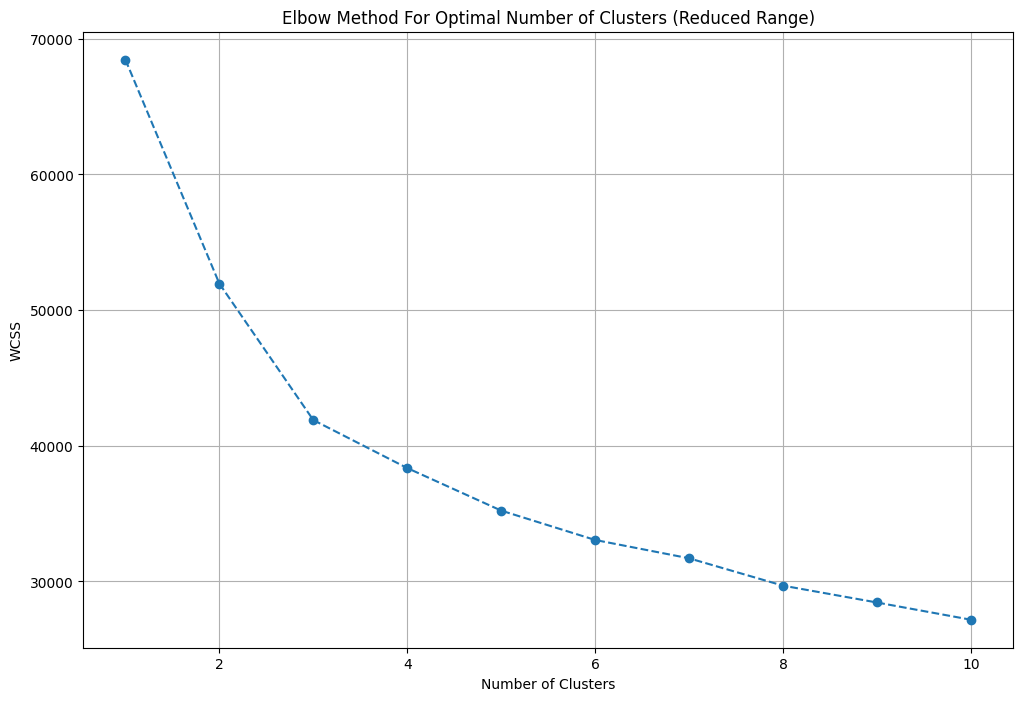

In [50]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [51]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [52]:
df.columns

Index(['property_type', 'sector', 'society', 'price', 'area', 'price_per_sqft',
       'built_up_area', 'carpet_area', 'super_built_up_area', 'bedRoom',
       'bathroom', 'balcony', 'additionalRoom', 'floorNum', 'facing',
       'agePossession', 'nearbyLocations', 'furnishDetails', 'features',
       'study room', 'servant room', 'store room', 'pooja room', 'others',
       'AC', 'Wardrobe', 'Stove', 'Water Purifier', 'Geyser', 'Dining Table',
       'Curtains', 'Exhaust Fan', 'Sofa', 'Modular Kitchen', 'Microwave',
       'Fan', 'TV', 'Light', 'Chimney', 'Washing Machine', 'Bed', 'Fridge'],
      dtype='object')

In [53]:
df = df.iloc[:,:24]

In [54]:
df.columns

Index(['property_type', 'sector', 'society', 'price', 'area', 'price_per_sqft',
       'built_up_area', 'carpet_area', 'super_built_up_area', 'bedRoom',
       'bathroom', 'balcony', 'additionalRoom', 'floorNum', 'facing',
       'agePossession', 'nearbyLocations', 'furnishDetails', 'features',
       'study room', 'servant room', 'store room', 'pooja room', 'others'],
      dtype='object')

In [55]:
df['furnishing_type'] = cluster_assignments

In [56]:
df['furnishing_type'].value_counts()

furnishing_type
1    2534
2    1057
0     212
Name: count, dtype: int64

In [57]:
furnishings_df['cluster'] = cluster_assignments
furnishings_df.groupby('cluster').mean().round(2)


,AC,Wardrobe,Stove,Water Purifier,Geyser,Dining Table,Curtains,Exhaust Fan,Sofa,Modular Kitchen,Microwave,Fan,TV,Light,Chimney,Washing Machine,Bed,Fridge
cluster,,,,,,,,,,,,,,,,,,
0,4.50,4.67,0.77,0.76,4.03,0.50,1.72,0.86,0.57,0.91,0.83,6.02,1.31,12.63,1.06,0.73,1.63,0.86
1,0.53,0.30,0.01,0.01,0.15,0.00,0.03,0.06,0.01,0.15,0.00,0.62,0.01,1.25,0.07,0.00,0.02,0.00
2,2.94,3.41,0.27,0.19,2.95,0.02,0.66,0.88,0.01,0.91,0.08,5.71,0.06,13.38,0.84,0.01,0.07,0.01


In [58]:
furnishings_df['total_items'] = furnishings_df.drop(columns=['cluster']).sum(axis=1)
furnishings_df.groupby('cluster')['total_items'].mean()


cluster
0    44.344340
1     3.207972
2    32.392621
Name: total_items, dtype: float64

In [59]:
df[['furnishDetails','furnishing_type']].sample(10)
# 1 --> unfurnished
# 2 --> semi
# 0 --> furnished

,furnishDetails,furnishing_type
3291,"['5 Fan', '1 Exhaust Fan', '1 Geyser', '6 Light', '1 Chimney', '3 Wardrobe', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",2
2471,"['10 Light', '4 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",1
3452,"['4 Wardrobe', '1 Water Purifier', '9 Fan', '1 Exhaust Fan', '3 Geyser', '12 Light', '2 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine']",2
320,"['1 Bed', '4 Wardrobe', '4 Fan', '8 Light', '3 AC', '1 Modular Kitchen', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",1
1070,NaN,1
2164,NaN,1
2411,NaN,1
1123,"['1 Exhaust Fan', '1 Light', '1 Curtains', '1 Wardrobe', 'No AC', 'No Bed', 'No Chimney', 'No Dining Table', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",1
2710,"['4 Wardrobe', '4 Fan', '4 Geyser', '12 Light', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",2
2207,"['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",1


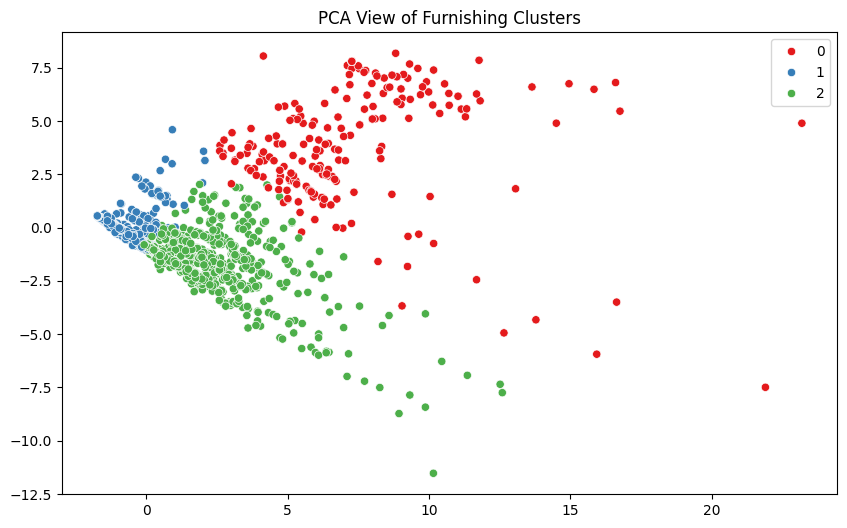

In [60]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=cluster_assignments, palette='Set1')
plt.title('PCA View of Furnishing Clusters')
plt.show()


In [61]:
df[['furnishDetails','furnishing_type']].head()

,furnishDetails,furnishing_type
0,NaN,1
1,"['2 Wardrobe', '4 Fan', '2 Geyser', '15 Light', '1 Modular Kitchen', '1 Chimney', '1 Curtains', 'No AC', 'No Bed', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",2
2,NaN,1
3,"['1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",1
4,"['4 Fan', '1 Exhaust Fan', '3 Geyser', '1 Stove', '8 Light', '1 Modular Kitchen', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",2


# features column

In [62]:
df[['society','features']].sample(5)

,society,features
1889,kashish manor one,"['Park', 'Club house / Community Center', 'Water softening plant']"
1506,shree vardhman victoria,"['Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Park', 'Natural Light', 'Airy Rooms', 'Spacious Interiors']"
2838,m3m heights,"['Power Back-up', 'Intercom Facility', 'Lift(s)', 'Swimming Pool', 'Park', 'Visitor Parking', 'Natural Light', 'Airy Rooms', 'Fitness Centre / GYM', 'Club house / Community Center', 'Water softening plant']"
74,bptp astaire gardens,"['Intercom Facility', 'Lift(s)', 'Swimming Pool', 'Park', 'Internet/wi-fi connectivity', 'Fitness Centre / GYM', 'Club house / Community Center']"
251,valley view estate,"['Feng Shui / Vaastu Compliant', 'Lift(s)', 'Maintenance Staff', 'Swimming Pool', 'Park', 'Visitor Parking', 'Security Personnel', 'Internet/wi-fi connectivity', 'Fitness Centre / GYM']"


In [63]:
df['features'].isnull().sum()

635

- the dataframe we working on has some socities whose features are NaN. To fill these null values will merge this dataframe with apartments.csv.
- apartments.csv file has socity names with respective ammenities in that society.
- Bascially will join 2 tables on the basis of society column to fill null values of features column 

In [64]:
appart_df = pd.read_csv('/Users/meetsudra/Documents/GitHub/real-estate/apartments.csv')
appart_df.sample(5)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
199,Conscient Habitat,"2, 3 BHK Apartment in Sector 99A, Gurgaon","['Dwarka Expressway', 'NH8']","{'Dwarka Expressway': 'In close proximity', 'NH8': 'In close proximity'}",https://www.99acres.com/conscient-habitat-sector-99a-gurgaon-npxid-r376695,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '445.53 - 551.91 sq.ft.', 'price-range': '₹ 26.06 - 32.25 L'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '645.84 sq.ft.', 'price-range': '₹ 37.41 L'}}","['Creche/Day care', 'Shopping Centre', 'Earthquake Resistant', 'Community Hall', 'Gated Community', 'Landscape Garden', ""Children's Play Area"", 'Lift(s)', 'Car Parking']"
95,Ramprastha Primera,"3 BHK Apartment in Sector 37D, Gurgaon","['Dwarka Expressway', 'JMS Marine Square Mall', 'Blue Bells Public School', 'Delhi Jaipur Expressway', 'infinity Business Park']","{'Dwarka Expressway': '1.9 Km', 'JMS Marine Square Mall': '4.3 Km', 'Blue Bells Public School': '4.5 Km', 'Delhi Jaipur Expressway': '5 Km', 'infinity Business Park': '9.9 Km', 'SGT University': '10 Km', 'Medanta The Medicity': '10.2 Km', 'Holiday Inn Gurugram Sector 90': '10.5 Km', 'HUDA Market': '13.6 Km', 'Indira Gandhi International Airport': '24.5 Km'}",https://www.99acres.com/ramprastha-primera-sector-37d-gurgaon-npxid-r4640,"{'3 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,695 - 1,800 sq.ft.', 'price-range': '₹ 1.22 - 1.96 Cr'}}","['Swimming Pool', 'Water Softener Plant', 'Theatre', 'Shopping Centre', 'Video Door Security', 'Multipurpose Court', 'Vastu Compliant', 'Multipurpose Hall', 'Yoga/Meditation Area']"
31,M3M Skycity,"2, 3 BHK Apartment in Sector 65, Gurgaon","['DPS International Edge', 'Eros City Square', 'Splendor Trade Tower', 'Narayana Junior College', 'CK Birla Hospital']","{'DPS International Edge': '1.4 Km', 'Eros City Square': '1.8 Km', 'Splendor Trade Tower': '2.5 Km', 'Narayana Junior College': '3.1 Km', 'CK Birla Hospital': '4 Km', 'DoubleTree by Hilton Hotel': '6 Km', 'Sector 55 Metro Station': '6.1 Km', 'SkyJumper Trampoline Park': '9 Km', 'Indira Gandhi Intl Airport': '22.9 Km'}",https://www.99acres.com/m3m-skycity-sector-65-gurgaon-npxid-r326899,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,280 sq.ft.', 'price-range': '₹ 1.6 - 2.05 Cr'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,800 - 2,000 sq.ft.', 'price-range': '₹ 2.25 - 3.2 Cr'}}","['Bus Shelter', 'Swimming Pool', 'Lounge', 'Bar/Chill-Out Lounge', 'Reflexology Park', 'School', 'Aerobics Centre', 'Terrace Garden', 'High Speed Elevators']"
59,Ansal API Esencia,"Land, 3, 4 BHK Independent Floor in Sector 67, Gurgaon","['Proposed Metro corridor', 'N.H-8', 'Golf Course Road', 'Shiskshantar', 'DPS']","{'Proposed Metro corridor': 'Close Proximity', 'N.H-8': 'Close Proximity', 'Golf Course Road': 'Close Proximity', 'Shiskshantar': 'Close Proximity', 'DPS': 'Close Proximity', 'Amity': 'Close Proximity', 'Pathways': 'Close Proximity', 'GD Goenka': 'Close Proximity', 'Medicity': 'Close Proximity', 'Artemis': 'Close Proximity', 'Max, Fortis': 'Close Proximity', 'Apollo': 'Close Proximity'}",https://www.99acres.com/ansal-api-esencia-sector-67-gurgaon-npxid-r3568,"{'3 BHK': {'building_type': 'Independent Floor', 'area_type': 'Super Built-up Area', 'area': '1,300 - 1,953 sq.ft.', 'price-range': '₹ 2 Cr'}, '4 BHK': {'building_type': 'Independent Floor', 'area_type': 'Super Built-up Area', 'area': '1,747 - 3,762 sq.ft.', 'price-range': '₹ 2.7 - 3.76 Cr'}, 'Land': {'building_type': '', 'area_type': 'Plot Area', 'area': '2,250 - 9,990 sq.ft.', 'price-range': 'Price on Request'}}","['Swimming Pool', 'Laundry', 'School', 'Solar Lighting', 'Terrace Garden', 'Creche/Day care', 'Grocery Shop', 'Shopping Centre', 'Video Door Security']"
35,Eldeco Acclaim,"2, 3 BHK Apartment in Sohna, Gurgaon","['G D Go

In [65]:
appart_df['PropertyName'] = appart_df['PropertyName'].str.lower()

In [66]:
temp_df = df[df['features'].isnull()]
temp_df.sample(2)

,property_type,sector,society,price,area,price_per_sqft,built_up_area,carpet_area,super_built_up_area,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,study room,servant room,store room,pooja room,others,furnishing_type
1612,flat,sector 12,lord krishna,2.70,3150.0,8571.0,3150.0,NaN,NaN,4,3,3,not available,6.0,North-East,Undefined,"['Huda city centre metro station', 'Hanuman Mandir', 'New Life Church', 'Standard chartered ATM', 'Hdfc bank ATM', 'Hdfc ATM', 'Icici ATM', 'Citi bank ATM', 'Axis bank ATM', 'Hdfc ATM', 'Axis bank ATM', 'State bank of india ATM', 'Axis bank ATM', 'Rbs ATM', 'Arihant Hospital', 'Gupta', 'Fortis Memorial Research Institute Fortis Vivekanand Hospital', 'Dr. Naval Mendiratta', 'Paras Hospital Gurgaon', 'Dr. Kutbuddin Akbary', 'Max Hospital', 'Dispencery', 'Centre For Sight Gurgaon Sector 29', 'Pernod Ricard Charitable Dispensary', 'City Medical', 'Gardian Pharmacy', 'Guardian Pharmacy', 'Chikitsa', 'Bharat petroleum', 'Hdfc bank', 'Icici bank', 'Hdfc bank', 'PWO house', 'Raj Restaurant', 'Balaji Vegetarian Paradise', 'The Chicken Boat', 'Naveidyam', 'Sagar Ratna', 'Cafe Tonini', 'St. Angels Sr', 'School of Inspired Leadership SOIL', 'St. Angels Jr', 'Stones2milestones', 'Amity Global School', 'Manav Rachna School', 'Manav Rachna Swimming Pool', 'Ncr library']","['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",NaN,0,0,0,0,0,1
748,flat,sector 11,global hill view,0.33,773.0,4271.0,761.0,NaN,NaN,2,2,0,not available,11.0,NaN,Undefined,NaN,NaN,NaN,0,0,0,0,0,1


In [67]:
temp_df.shape

(635, 25)

In [68]:
x = temp_df.merge(appart_df,left_on='society', right_on='PropertyName',how='left')['TopFacilities']

In [69]:
df.loc[temp_df.index,'features'] = x.values

In [70]:
df['features'].isnull().sum()

481

In [71]:
df.head(1)

,property_type,sector,society,price,area,price_per_sqft,built_up_area,carpet_area,super_built_up_area,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,study room,servant room,store room,pooja room,others,furnishing_type
0,flat,sector 86,ansal heights 86,0.78,1360.0,5735.0,1360.0,NaN,NaN,2,2,2,not available,8.0,North,New Property,"['IRIS Broadway Mall', 'Delhi Jaipur Expressway', 'Shishu Kalyan Senior Secondary School', 'Aarvy Healthcare Hospital']",NaN,"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Swimming Pool', 'Water Storage', 'Park', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Rain Water Harvesting']",0,0,0,0,0,1


#### ast.literal_eval(x)
- It's a safe Python function from the ast module.

- It converts strings that look like Python literals (e.g., lists, dicts, strings, numbers) into actual Python objects.

#### MultiLabelBinarizer from sklearn.preprocessing
- It's a special one-hot encoder for columns where each row contains multiple labels (i.e., lists).

- It's commonly used when:
One row can have multiple items from the same category.



In [72]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

- here feature column has ammenities offered by socities. So here also we could have encoded each column and then would have clustered each column into luxury, semi-luxury and non-luxury classes but while applying elbow method we were only recieving two classes, and on k means we found that luxury class had all the ammenities consisting rows and non-luxury simply had rows with no ammenities at all. 
- Thus, luxury-score was the approach that was implemented wherein, we first assigned weights to each of the ammenities through chat-gpt, and depending upon the number of ammenities in a row we assigned luxury-score to it. 

In [73]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)

In [74]:
df['luxury_score'] = luxury_score

In [75]:
df.sample(5)

,property_type,sector,society,price,area,price_per_sqft,built_up_area,carpet_area,super_built_up_area,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
1569,flat,sohna road,trisara our homes 3,0.40,610.0,6561.0,NaN,602.0,NaN,2,2,1,not available,0.0,South,New Property,"['Metro Station', 'Gyanchand Market', 'Rajiv Chowk', 'KMP Expressway', 'Govt.Sr.Sec School(boys)', 'Jindal College', 'Kidzee', 'Vishvakarma Mandir', 'Mamta Hospital', 'Fortis', 'IGI T3', 'Oriental Bank of Commerce', 'Rajiv Gandhi Park']","['4 Fan', '1 Exhaust Fan', '1 Geyser', '10 Light', '10 Curtains', 'No AC', 'No Bed', 'No Chimney', 'No Dining Table', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Water softening plant']",0,0,0,0,0,2,"[Intercom Facility, Lift(s), Maintenance Staff, Water Storage, Visitor Parking, Swimming Pool, Park, Security Personnel, Natural Light, Airy Rooms, Low Density Society, Shopping Centre, Fitness Centre / GYM, Club house / Community Center, Water softening plant]",90
189,house,sector 3,independent,0.55,750.0,7333.0,750.0,NaN,NaN,1,1,0,not available,1.0,NaN,Undefined,"['Chintapurni Mandir', 'State bank ATM', 'Prateek Nursing Home And Polyclinic', 'Shree Krishna Hospital Gurgaon', 'Kr Dental Hub', 'Dr. Hitesh Dawar', 'Sneh Hospital Gurgaon', 'Jain Sant Phool Chand Ji Charitable Hospital', 'Sarvodya Hospital', 'Bhardwaj Hospital', 'Esic Hospital Gurugram', 'Dr. Ashok Jain', 'Dr. Sindhu Clinic', 'Gurgaon Eye Centre', 'Pearl Dental Clinic', 'Dr. Mittal Clinic', 'Jiya Clinic', 'R K Hospital Gurgaon', 'Yashroop Medical Centre', ""Dr. Anurag's Child Care Clinic"", 'Taneja Hospital', 'Aryan Hospital', 'Chirag Hospital Pvt. Ltd', 'Geeta Nursing Home Gurgaon', 'D.R. Rajnis Gupta Clinic', 'Sparsh Hospital Gurgaon', 'Ravi Clinic and Health Care Centre', 'Chiranjiv Hospital', 'Dr. Madan Clinic', 'Bhatnagar Maternity and Nursing Home', 'Dr. Agya Ram Sharma Clinic', 'Dev Man Kathuria Clinic', 'GH Gurgaon', 'Swastik Maternity and Medical Centre', 'Bindal Clinic', 'Dr. Sarvejeet Singh', 'M.S Hospital', 'My Care Clinic', 'Satyam Hospital Gurgaon', 'Indian bank', 'Kotak bank', 'Hdfc bank', 'State bank of india', 'Pizza Hut', 'St. Michaels Sr. Sec. School', 'Dronacharya Government College', 'Gurgaon railway station', 'Gurgaon railway station', 'Gurgaon railway station']","['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",NaN,0,0,0,0,0,1,[],0
3294,flat,sector 50,unitech harmony,2.60,2711.0,9590.0,2700.0,2200.0,2711.0,3,4,2,"servant room,others",15.0,North-East,Relatively New,"['Huda Metro Station (Gurugram)', 'M3M Cosmopolitan Mall', 'Golf Course Ext Road', 'The Sylvan Trails School', 'Gurugram University', 'Park Hospital', 'Indira Gandhi International Airport', 'Leisure Valley Park', 'Vipul Trade Centre', 'Hyatt Regency Hotel', ""Oyster's Water Park"", 'DLF Golf and Country Club', 'F9 Go Karting Gurgaon']","['3 Wardrobe', '7 Fan', '1 Exhaust Fan', '4 Geyser', '1 Stove', '15 Light', '3 Curtains', '4 AC', '1 Chimney', '1 Modular Kitchen', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling H

In [76]:
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [77]:
df.sample(2)

,property_type,sector,society,price,area,price_per_sqft,built_up_area,carpet_area,super_built_up_area,bedRoom,bathroom,balcony,floorNum,facing,agePossession,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
3665,flat,sector 70a,aipl the peaceful homes,1.6,1669.0,9584.0,NaN,NaN,1565.0,2,2,2,22.0,North,Moderately Old,0,0,0,0,0,1,86
3584,flat,sector 110,mahindra aura,1.4,1450.0,9655.0,1550.0,1450.0,1615.0,3,3,3,10.0,North,Relatively New,0,0,0,0,0,2,142


In [78]:
df.to_csv('feature_engineered_gurgaon.csv',index=False)